In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm

plt.rcParams.update({
    "text.usetex": True,       
    "font.family": "serif",
    "figure.dpi": 110,        
    "figure.autolayout": True,
    "text.usetex": True,
})

DATA_DIR = Path(".")        
HIST_DIR = DATA_DIR / "model" 
OUT_DIR = Path("plots")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# Data Preprocessing

In [69]:
import re

def build_tag(row) -> str:
    """Создаём tag точно так же, как в run_all.py"""
    aug = "aug" if bool(row["augmix"]) else "noaug"
    return (
        f"{row["dataset"]}_{row["model"]}_{row["loss"]}"
        f"_ls{row['ls']}_mx{row['mixup']}_{aug}"
    )

_num  = r"(?:[0-9]+(?:\.[0-9]+)?)"      # 0, 0.0, 0.2, 10, 10.25 …

PAT = re.compile(
    rf"^(?P<dataset>[^_]+)_"            # cifar10
    rf"(?P<model>[^_]+)_"               # resnet50
    rf"(?P<loss>.+?)_"                  # cross_entropy / dual_focal / bsce_gra
    rf"ls(?P<ls>{_num})_"               # ls0   или ls0.1
    rf"mx(?P<mixup>{_num})_"            # mx0.2
    rf"(?P<augmix>aug|noaug)$"          # aug | noaug
)

def parse_config(tag: str) -> dict:
    m = PAT.match(tag)
    if not m:
        raise ValueError(f"не удалось распарсить tag: {tag}")
    d = m.groupdict()
    d["ls"]     = float(d["ls"])
    d["mixup"]  = float(d["mixup"])
    d["augmix"] = d["augmix"] == "aug"
    return d

def method_group(loss, ls, mixup, augmix) -> str:
    """Правила категоризации"""
    baseline = (
        (loss == "cross_entropy")
        and ls == 0
        and mixup == 0
        and not augmix
    )
    if baseline:
        return "Baseline"

    parts = []
    if loss != "cross_entropy":
        parts.append("AltLoss")
    if (ls > 0) or (mixup > 0) or augmix:
        parts.append("RegAug")
    return "+".join(parts)

def regaug_group(ls, mixup, augmix) -> str:
    """Правила категоризации RegAug"""
    baseline = (ls == 0 and mixup == 0 and not augmix)
    if baseline:
        return "Baseline"
    elif ls:
        return "Label Smoothing"
    elif mixup:
        return "MixUp"
    elif augmix:
        return "AugMix"


# Для удобства приведём названия колонок к snake_case
def normalize_cols(df):
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

In [79]:
test_df  = pd.read_csv(DATA_DIR / "test_master.csv")
test_df["accuracy"] = test_df["accuracy"] / 100.0
calib_df = pd.read_csv(DATA_DIR / "calib_master.csv")

histories = []
for csv_path in HIST_DIR.rglob("history.csv"):
    cfg_name = csv_path.parent.name                # имя папки == конфигу
    df = pd.read_csv(csv_path)
    df["config"] = cfg_name
    histories.append(df)

hist_df = pd.concat(histories, ignore_index=True)
hist_df.columns = [c.lower() for c in hist_df.columns]

test_df  = normalize_cols(test_df)
calib_df = normalize_cols(calib_df)


In [80]:
for df in (test_df, calib_df):
    if "config" not in df.columns:
        df["config"] = df.apply(build_tag, axis=1)

parsed = pd.DataFrame(hist_df["config"].apply(parse_config).tolist())
hist_df = pd.concat([hist_df, parsed], axis=1)


test_df["method"] = test_df.apply(
    lambda r: method_group(r["loss"], r["ls"], r["mixup"], r["augmix"]), axis=1
)

hist_df["method"] = hist_df.apply(
    lambda r: method_group(r["loss"], r["ls"], r["mixup"], r["augmix"]), axis=1
)

calib_df["method_group"] = "Post-hoc" + "+" + calib_df.apply(
                                            lambda r: method_group(r["loss"], r["ls"], r["mixup"], r["augmix"]), axis=1
                                        )

calib_df.rename(columns={"method": "calibrator"}, inplace=True)
calib_df.rename(columns={"method_group": "method"}, inplace=True)

rename_loss_dict = {
        "cross_entropy" : "Cross Entropy Loss",
        "focal" : "Focal Loss",
        "dual_focal" : "Dual Focal Loss",
        "bsce_gra" : "BSCE-GRA"
    }

for df in (test_df, calib_df, hist_df):
    df["RegAug"] = df.apply(
        lambda r: regaug_group(r["ls"], r["mixup"], r["augmix"]), axis=1
    )
    df["loss"]    = df["loss"].replace(rename_loss_dict)
    df["dataset"] = df["dataset"].astype("category")
    df["method"]  = df["method"].astype("category")
    df["loss"]    = df["loss"].astype("category")
    df["RegAug"]  = df["RegAug"].astype("category")

In [72]:
test_df.head()

,dataset,model,loss,ls,mixup,augmix,accuracy,ece,adaece,classece,brier,config,method,RegAug
0,cifar10,resnet50,Cross Entropy Loss,0.0,0.0,False,0.7302,0.010877,0.010893,0.627379,0.370983,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Baseline,Baseline
1,cifar10,resnet50,Cross Entropy Loss,0.1,0.0,False,0.7749,0.055479,0.055181,0.629715,0.326433,cifar10_resnet50_cross_entropy_ls0.1_mx0.0_noaug,RegAug,Label Smoothing
2,cifar10,resnet50,Cross Entropy Loss,0.0,0.2,False,0.7635,0.042814,0.043310,0.630542,0.331881,cifar10_resnet50_cross_entropy_ls0.0_mx0.2_noaug,RegAug,MixUp
3,cifar10,resnet50,Cross Entropy Loss,0.0,0.0,True,0.7545,0.034155,0.033997,0.683849,0.339672,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_aug,RegAug,AugMix
4,cifar10,resnet50,Focal Loss,0.0,0.0,False,0.7346,0.113463,0.113201,0.552716,0.386456,cifar10_resnet50_focal_ls0.0_mx0.0_noaug,AltLoss,Baseline


In [73]:
calib_df.head()

,dataset,model,calibrator,loss,ls,mixup,augmix,accuracy,ece,adaece,classece,brier,config,method,RegAug
0,cifar10,resnet50,temperature,Cross Entropy Loss,0.0,0.0,False,0.7302,0.017804,0.015282,0.652028,0.371175,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Post-hoc+Baseline,Baseline
1,cifar10,resnet50,platt,Cross Entropy Loss,0.0,0.0,False,0.7426,0.026271,0.025239,0.665824,0.351953,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Post-hoc+Baseline,Baseline
2,cifar10,resnet50,isotonic,Cross Entropy Loss,0.0,0.0,False,0.7342,0.025670,0.024181,0.653142,0.366222,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Post-hoc+Baseline,Baseline
3,cifar10,resnet50,bbq,Cross Entropy Loss,0.0,0.0,False,0.1616,0.021466,0.022395,0.373041,0.877129,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Post-hoc+Baseline,Baseline
4,cifar10,resnet50,temperature,Cross Entropy Loss,0.1,0.0,False,0.7749,0.032281,0.029361,0.666287,0.324138,cifar10_resnet50_cross_entropy_ls0.1_mx0.0_noaug,Post-hoc+RegAug,Label Smoothing


In [74]:
hist_df.head()

,epoch,train_loss,val_loss,val_acc,val_ece,val_adaece,val_classece,val_brier,config,dataset,model,loss,ls,mixup,augmix,method,RegAug
0,0,16.743919,2.375147,9.36,0.016933,0.017036,0.338464,0.901285,cifar10_resnet50_dual_focal_ls0_mx0.2_noaug,cifar10,resnet50,Dual Focal Loss,0.0,0.2,False,AltLoss+RegAug,MixUp
1,1,2.338861,2.349723,9.38,0.013266,0.017614,0.579440,0.901034,cifar10_resnet50_dual_focal_ls0_mx0.2_noaug,cifar10,resnet50,Dual Focal Loss,0.0,0.2,False,AltLoss+RegAug,MixUp
2,2,2.338044,2.323183,10.60,0.002015,0.014083,0.739342,0.899932,cifar10_resnet50_dual_focal_ls0_mx0.2_noaug,cifar10,resnet50,Dual Focal Loss,0.0,0.2,False,AltLoss+RegAug,MixUp
3,3,2.341838,2.338370,9.26,0.013709,0.013709,0.418616,0.900758,cifar10_resnet50_dual_focal_ls0_mx0.2_noaug,cifar10,resnet50,Dual Focal Loss,0.0,0.2,False,AltLoss+RegAug,MixUp
4,4,2.338008,2.338637,9.66,0.009713,0.011481,0.342305,0.900643,cifar10_resnet50_dual_focal_ls0_mx0.2_noaug,cifar10,resnet50,Dual Focal Loss,0.0,0.2,False,AltLoss+RegAug,MixUp


# Plots
Для начала сравним бейслайн со всеми другими методами в без конкретизации

In [75]:
history_val_metrics_cols = ['val_loss', 'val_acc', 'val_ece', 'val_adaece', 'val_classece', 'val_brier']

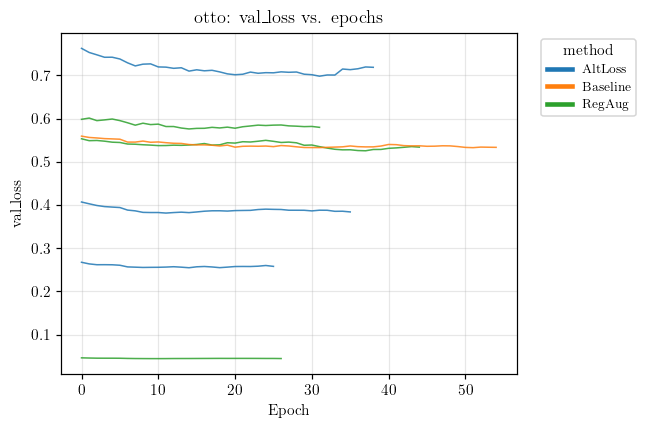

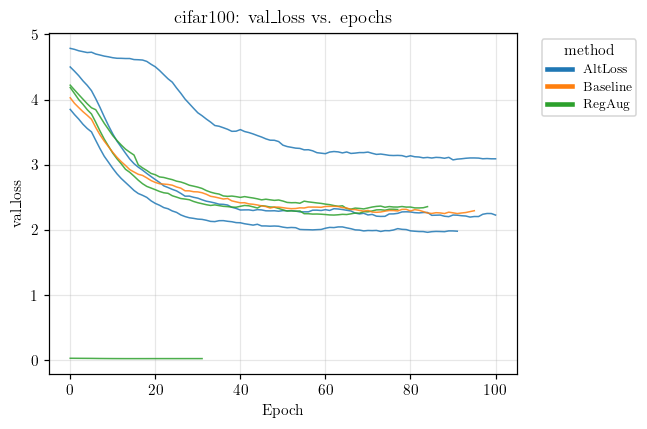

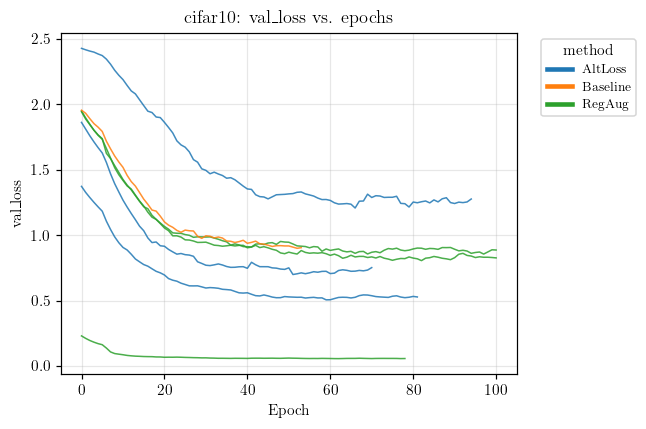

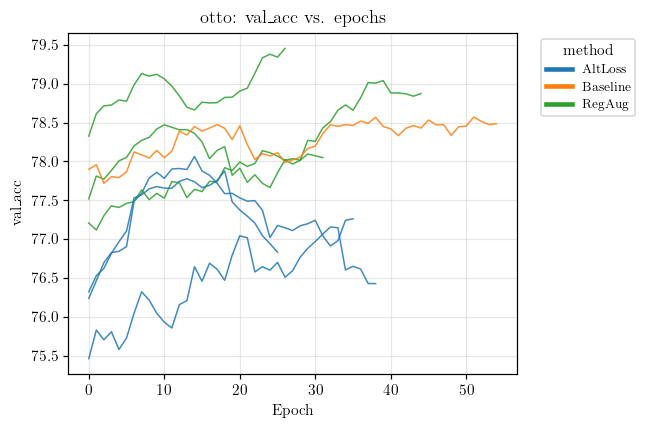

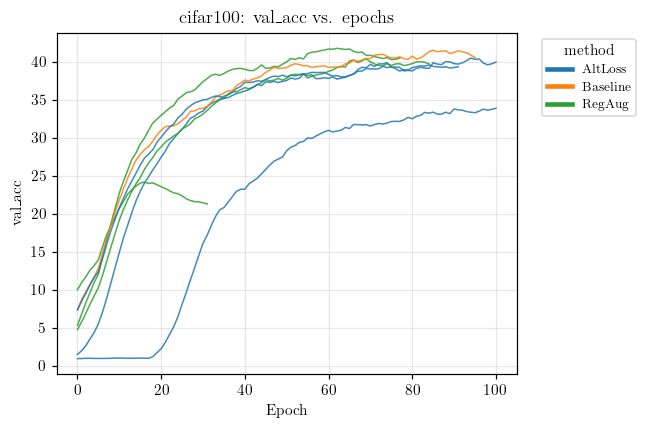

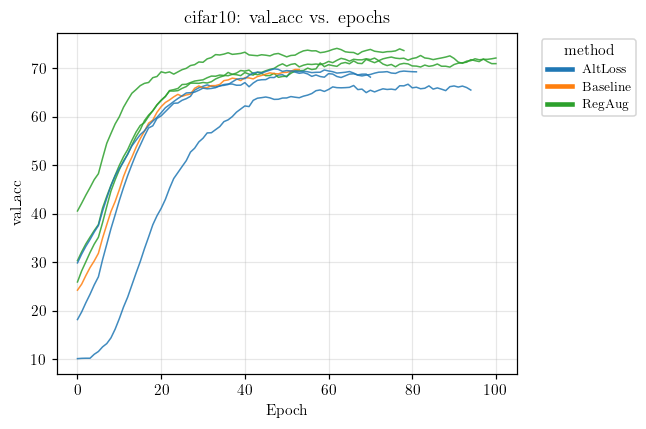

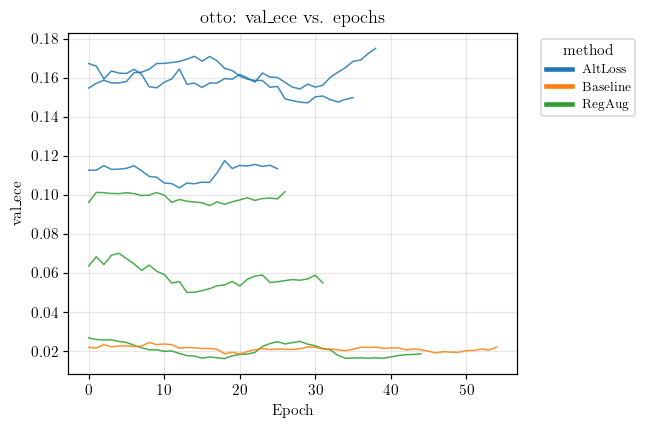

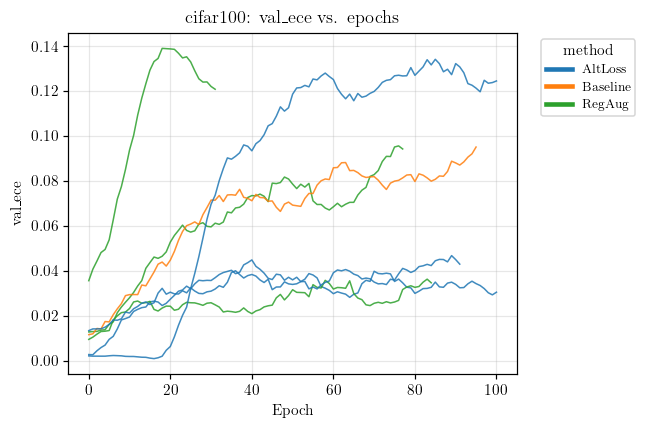

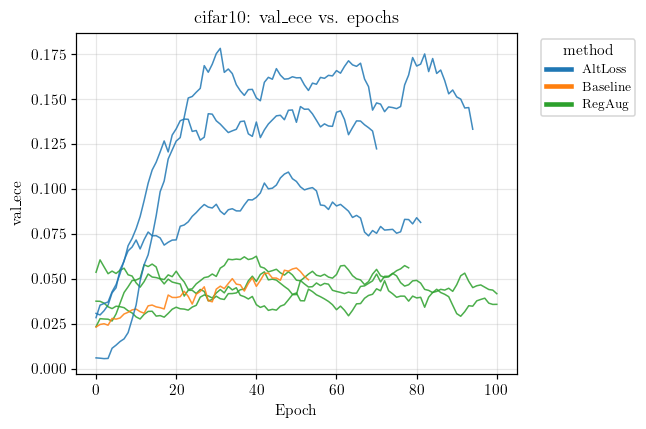

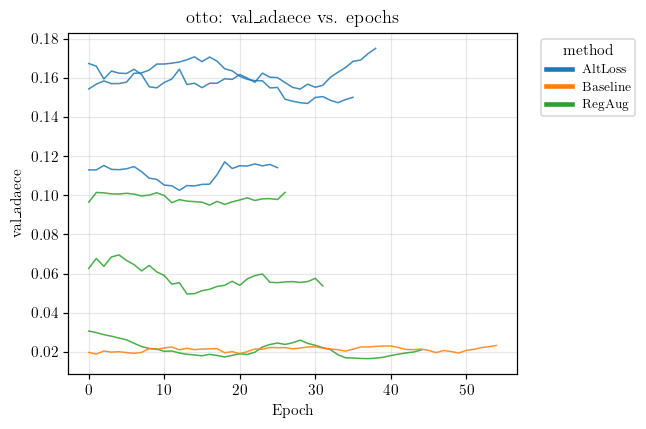

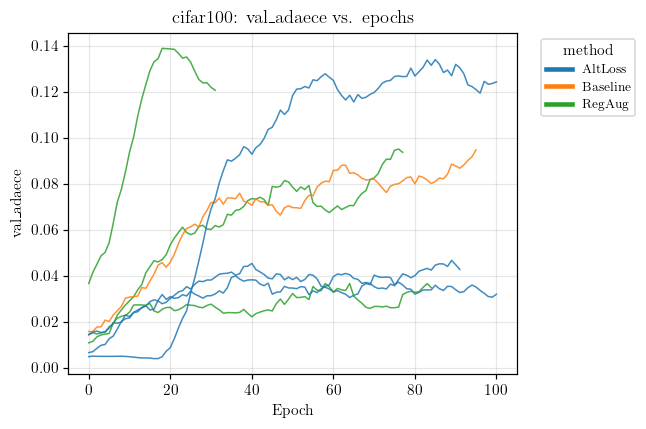

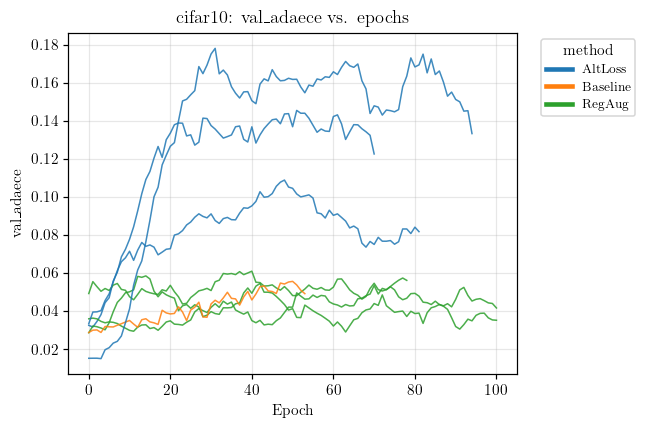

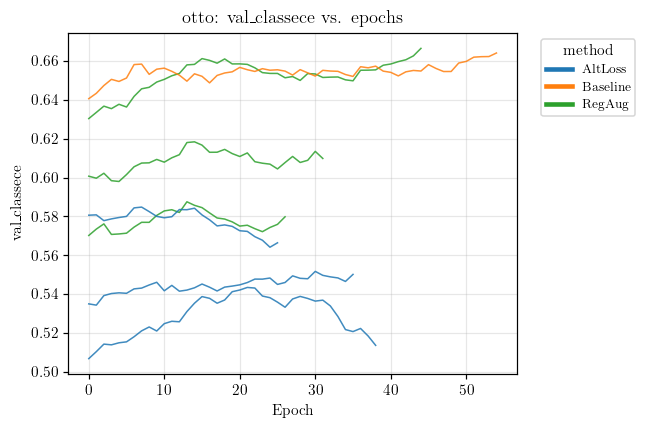

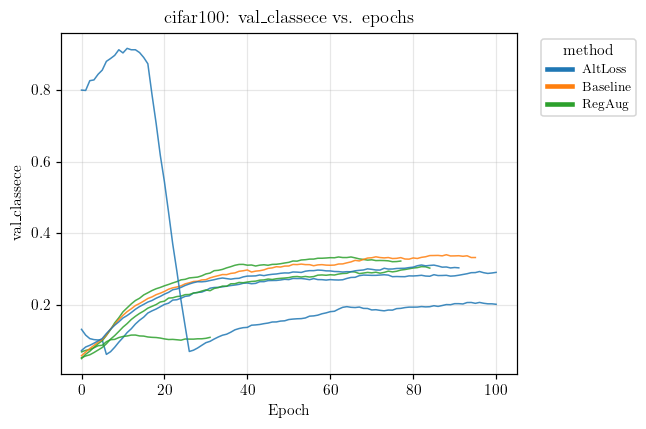

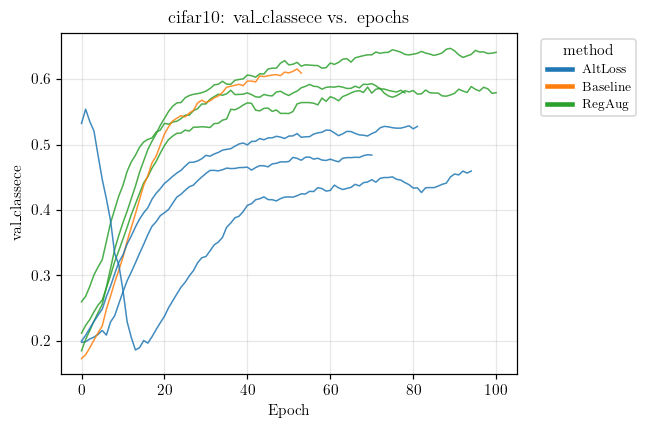

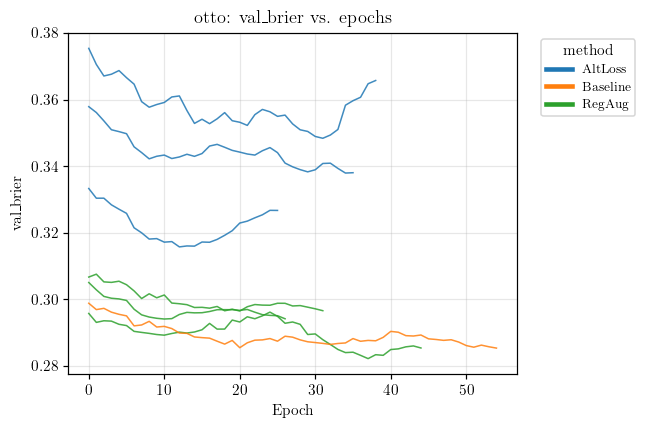

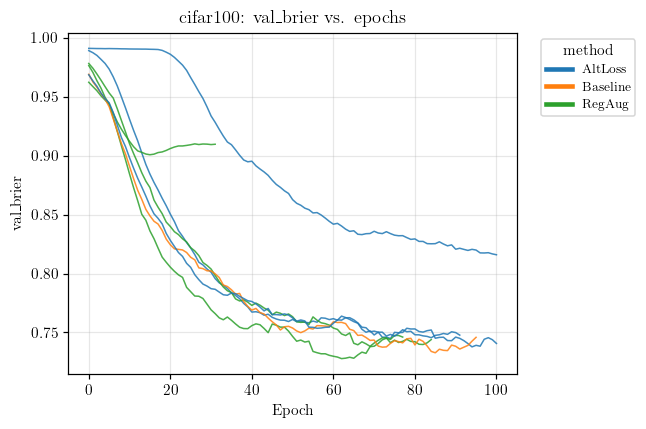

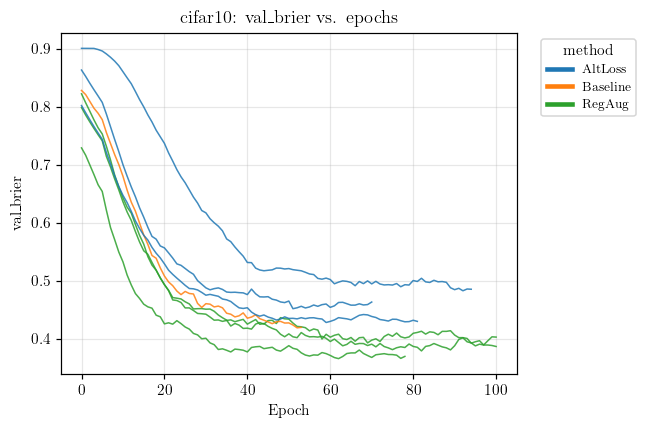

In [76]:
from src.utils_plot import plot_metric_ds

aggregated_path = OUT_DIR / 'aggregated'

mask = hist_df['method'].isin(['Baseline', 'AltLoss', 'RegAug'])
sub  = hist_df[mask].copy()
sub["method"] = sub["method"].cat.remove_unused_categories()

for metric in history_val_metrics_cols:
    plot_metric_ds(sub, metric=metric, smooth_window=10, max_epoch=100, save_pdf=True, path_to_dir=aggregated_path)

Начинаем смотреть по каждому методу по отдельности

AltLoss

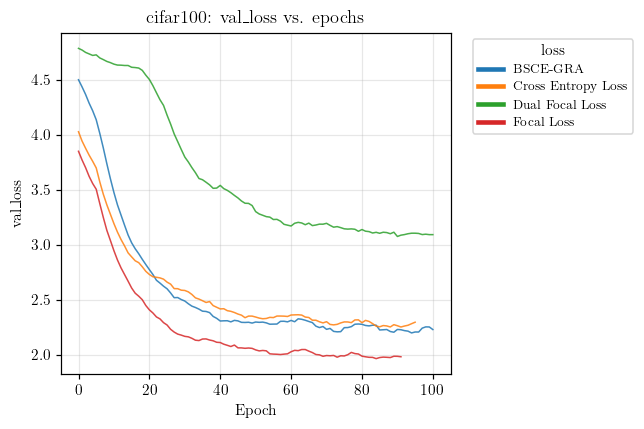

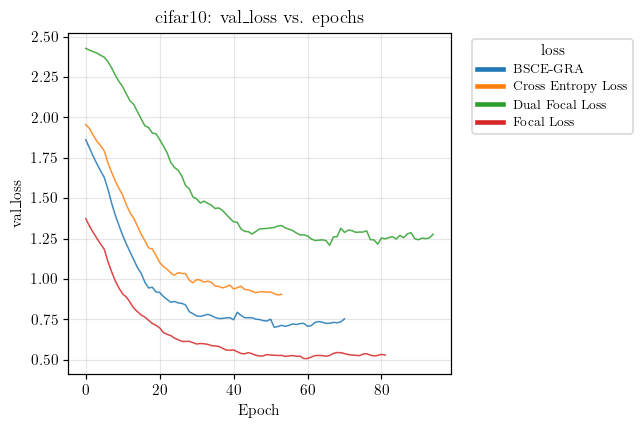

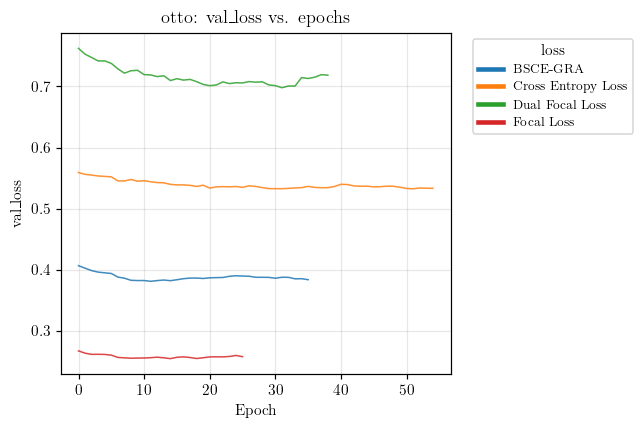

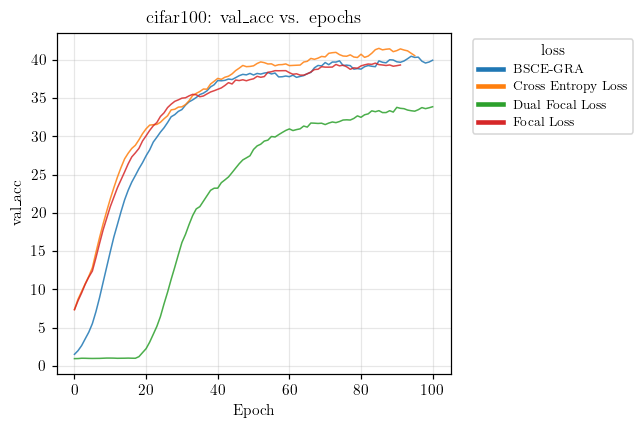

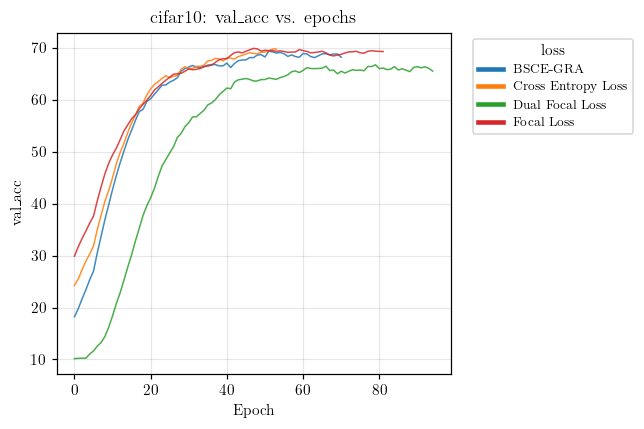

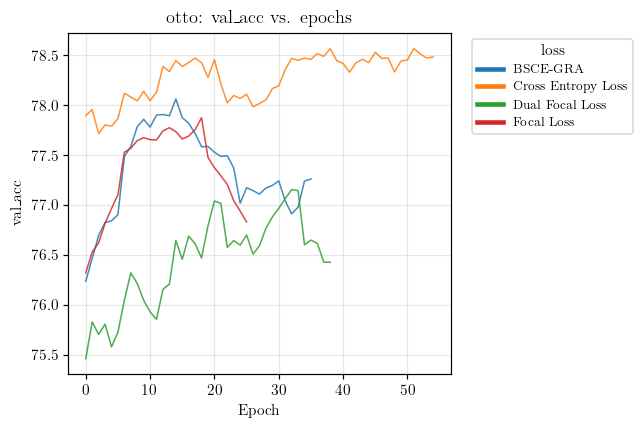

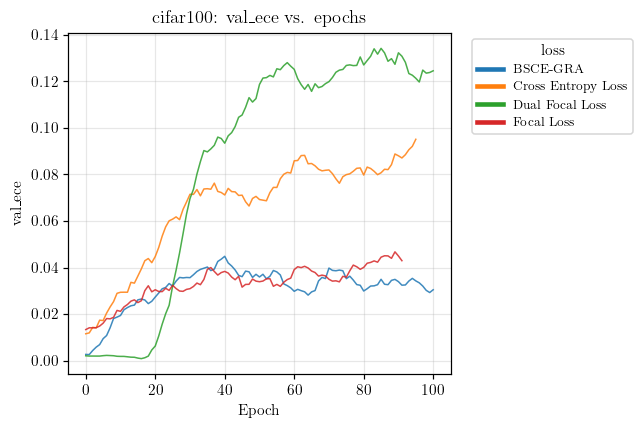

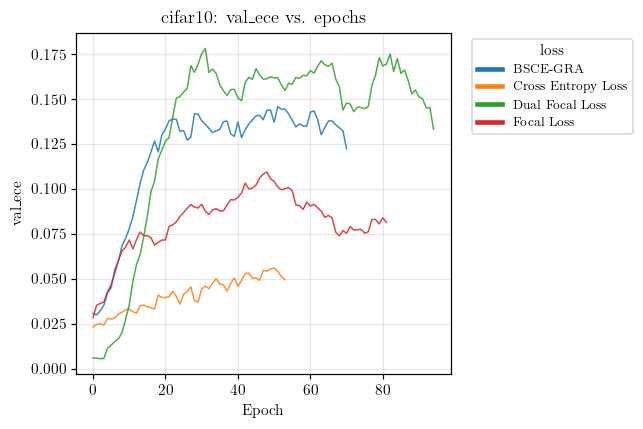

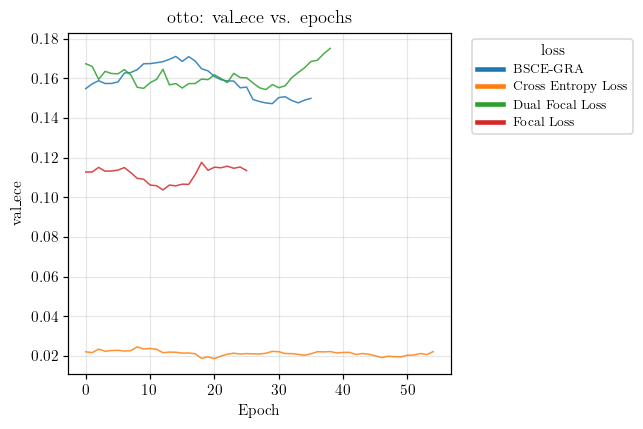

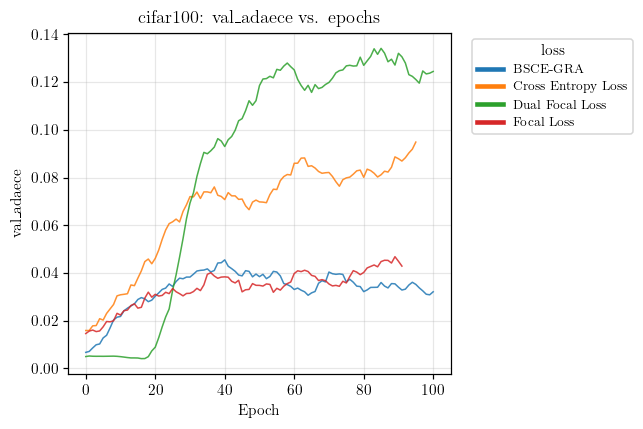

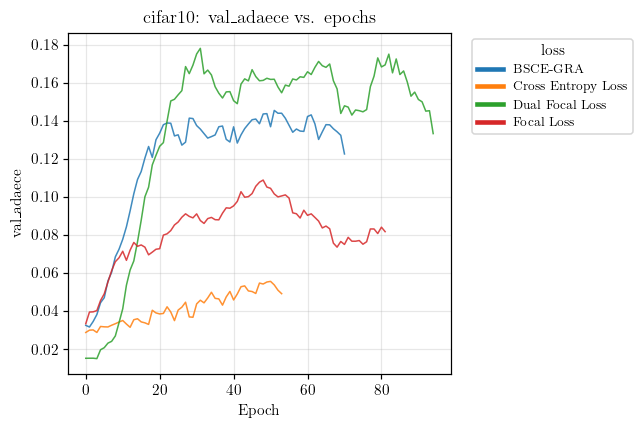

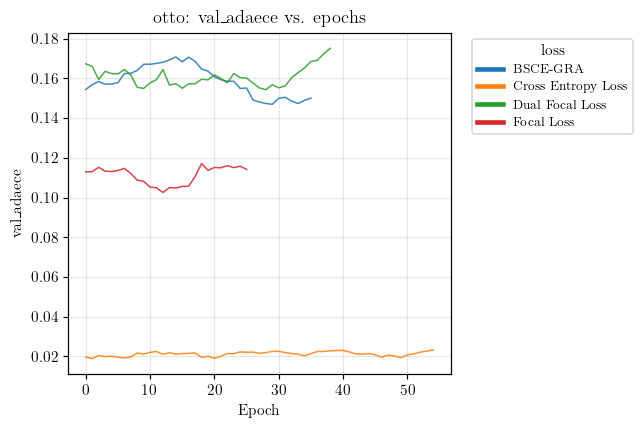

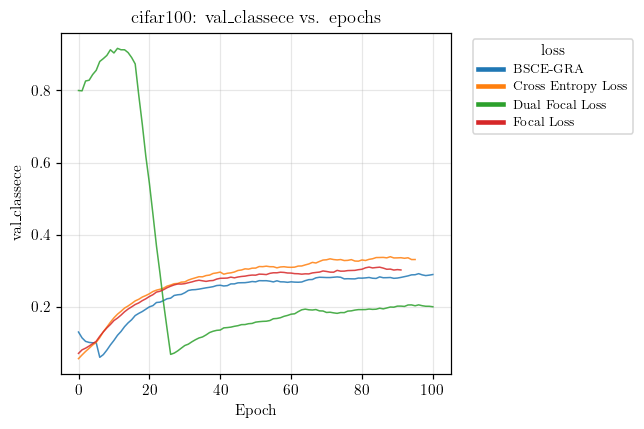

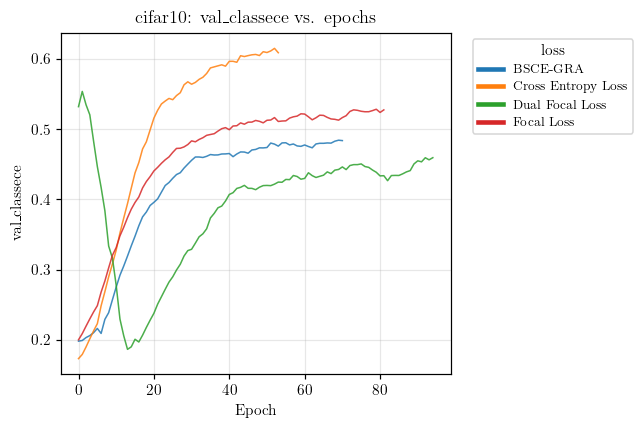

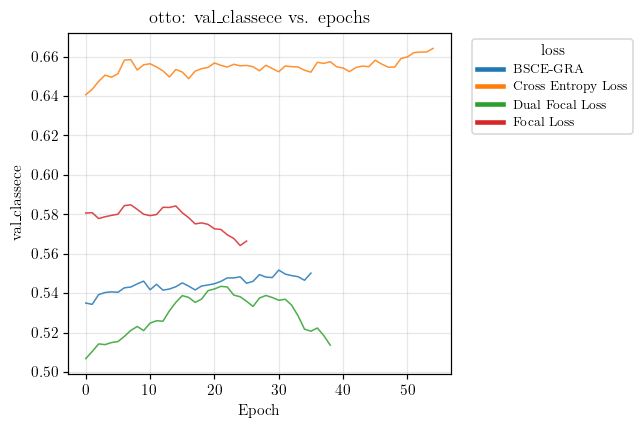

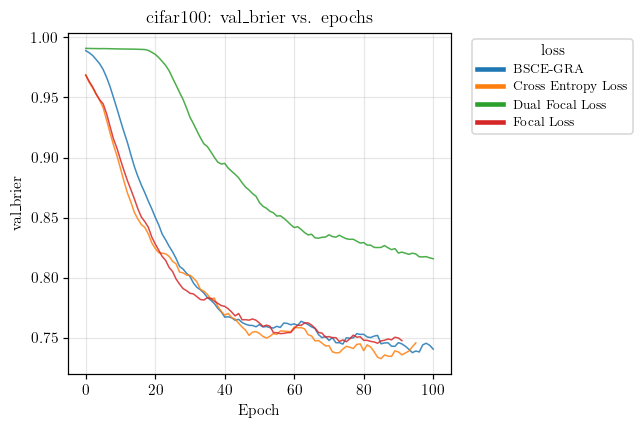

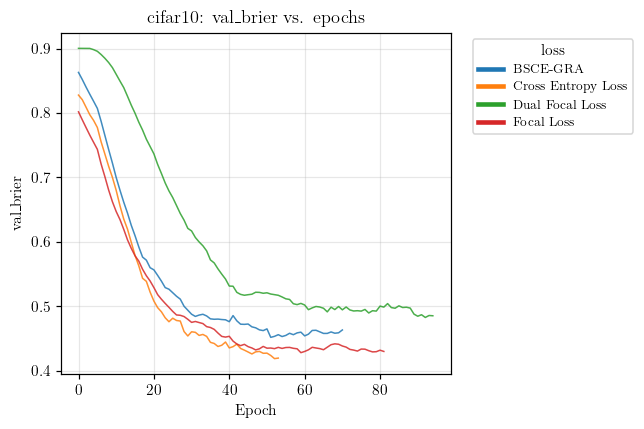

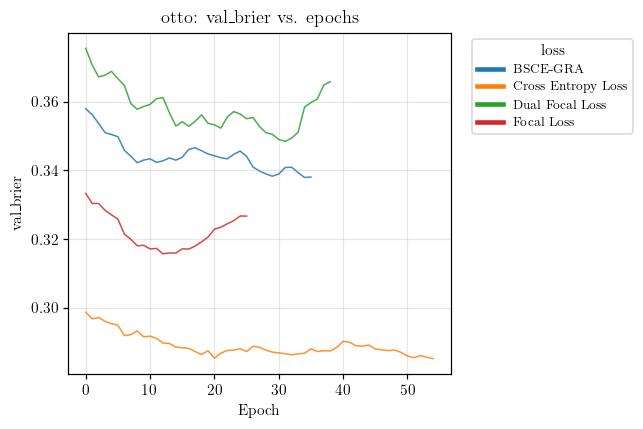

In [77]:
from src.utils_plot import plot_metric_ds

aggregated_path = OUT_DIR / 'AltLoss'

mask = hist_df['method'].isin(['Baseline', 'AltLoss'])
sub  = hist_df[mask].copy()
sub["method"] = sub["method"].cat.remove_unused_categories()

for metric in history_val_metrics_cols:
    plot_metric_ds(sub, metric=metric, smooth_window=10, max_epoch=100, hue='loss', save_pdf=True, path_to_dir=aggregated_path)


RegAug

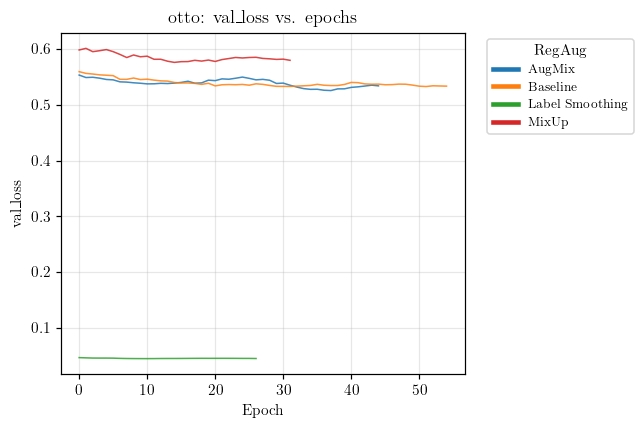

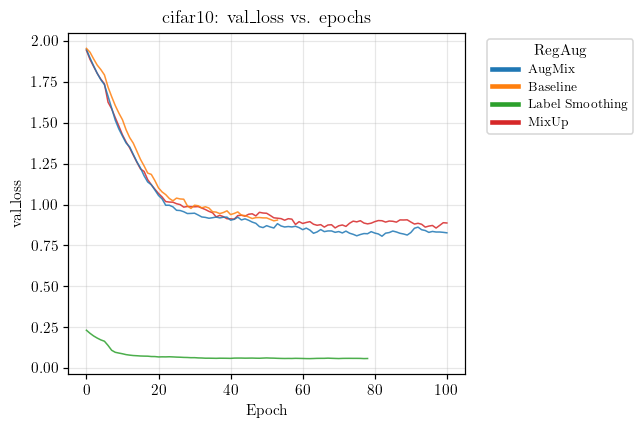

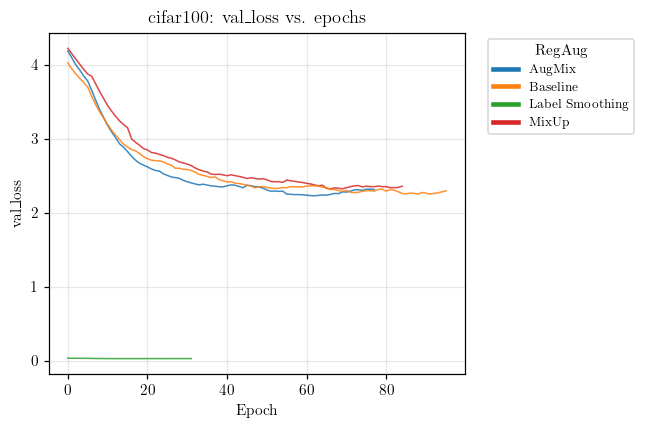

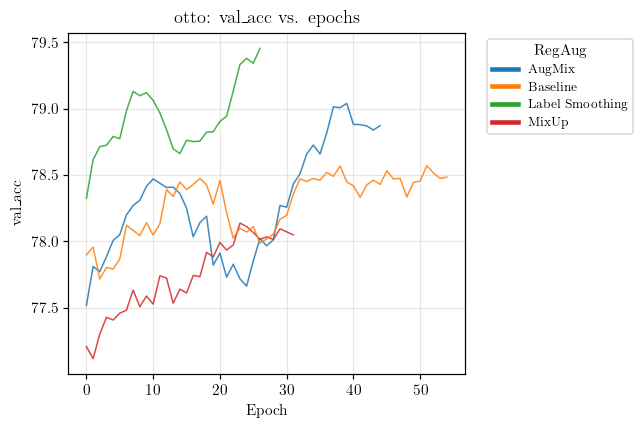

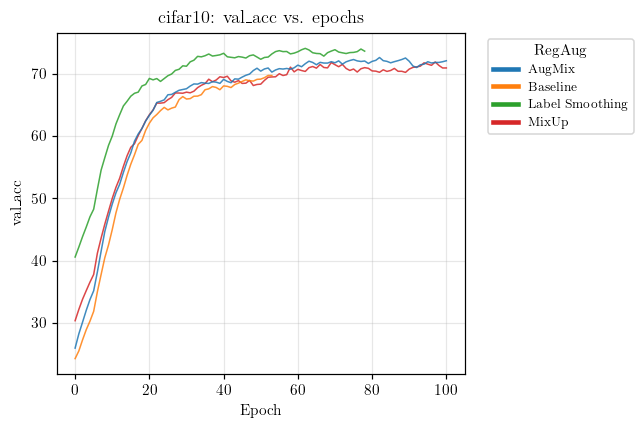

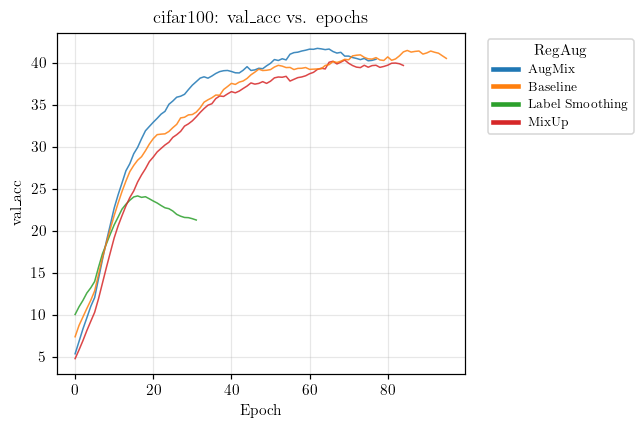

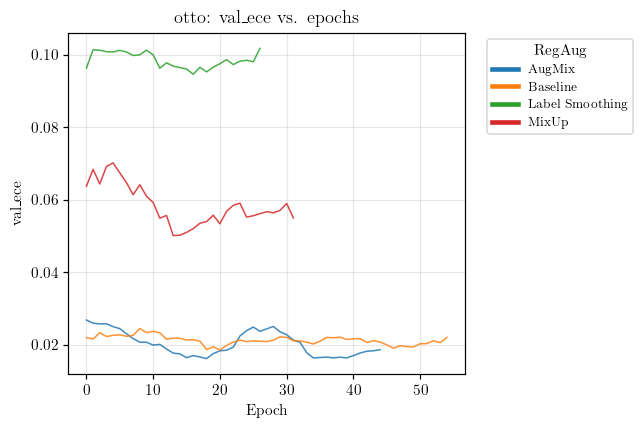

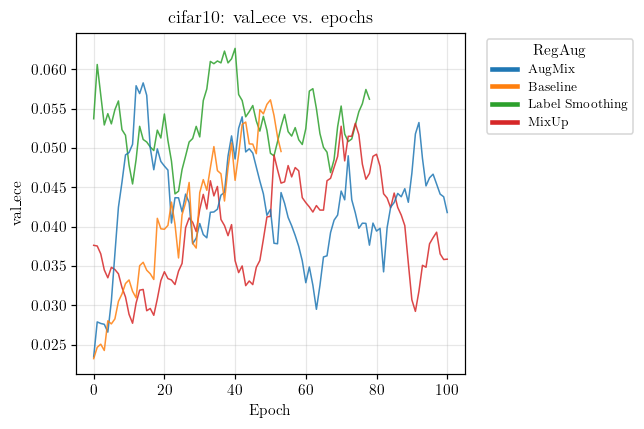

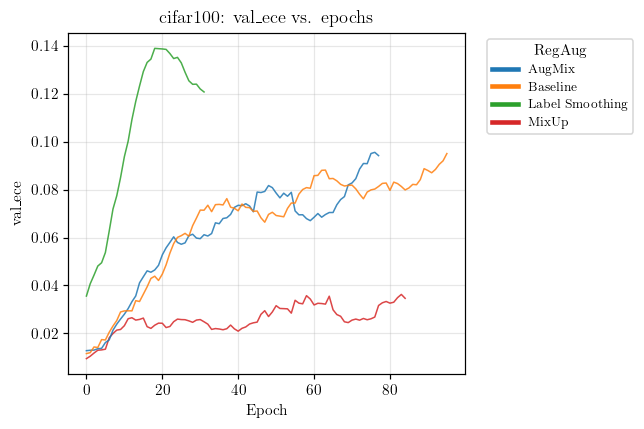

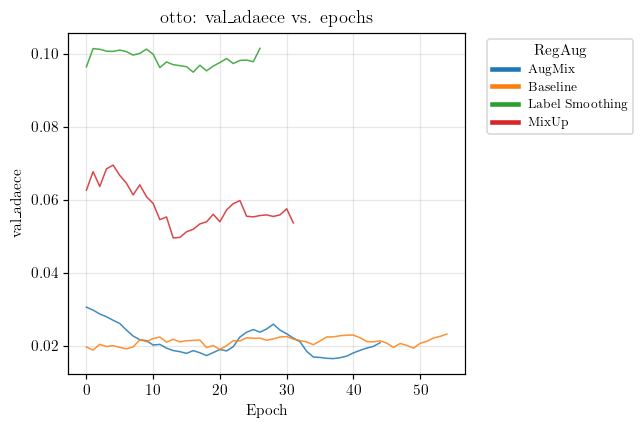

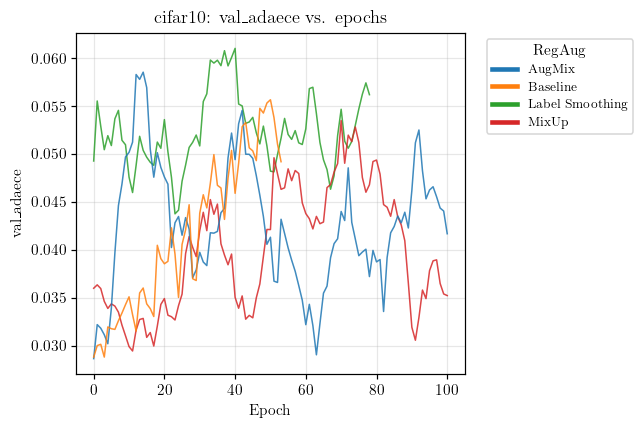

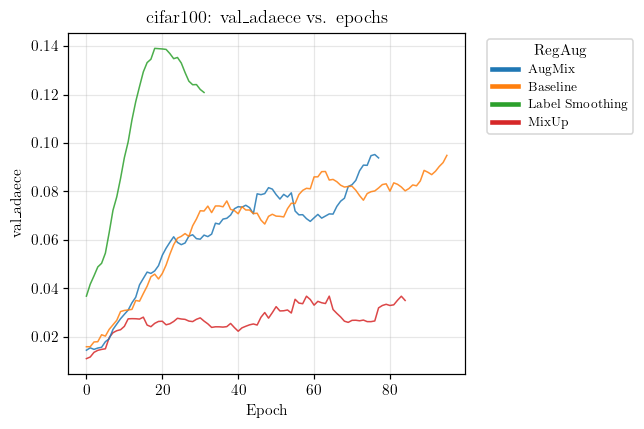

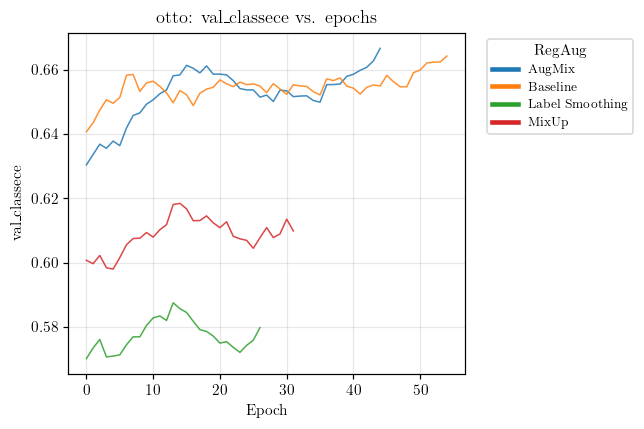

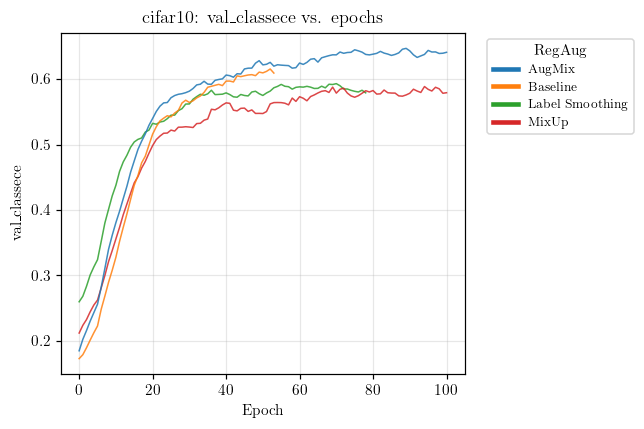

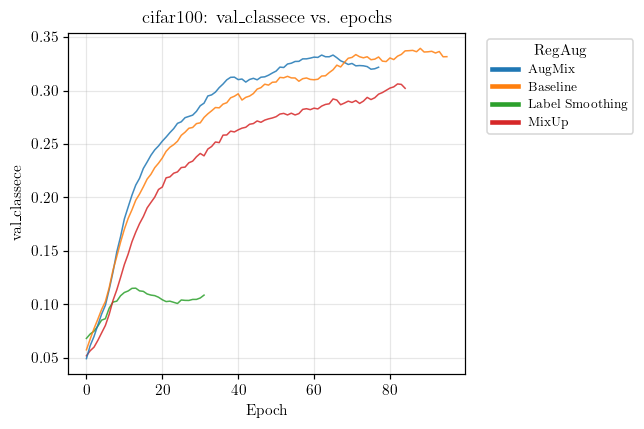

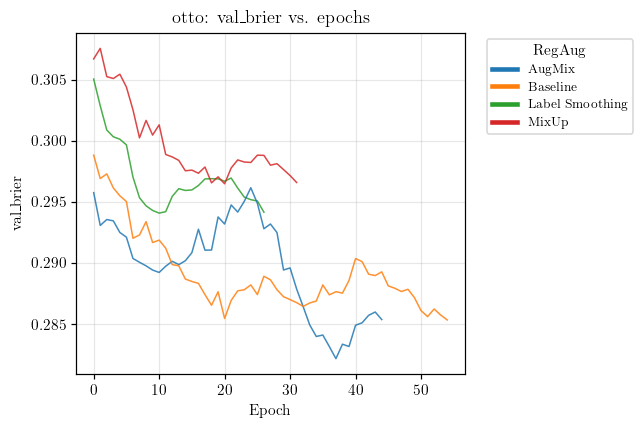

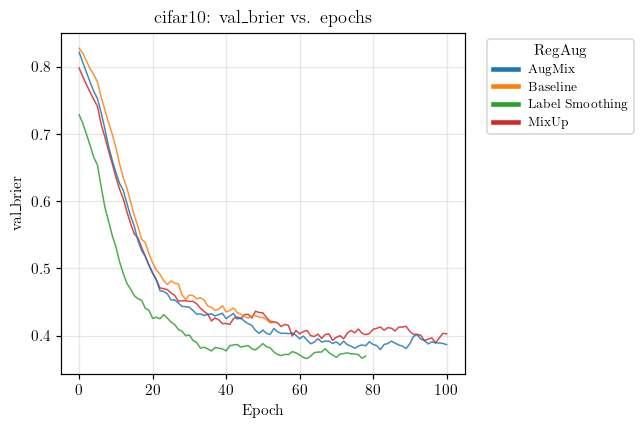

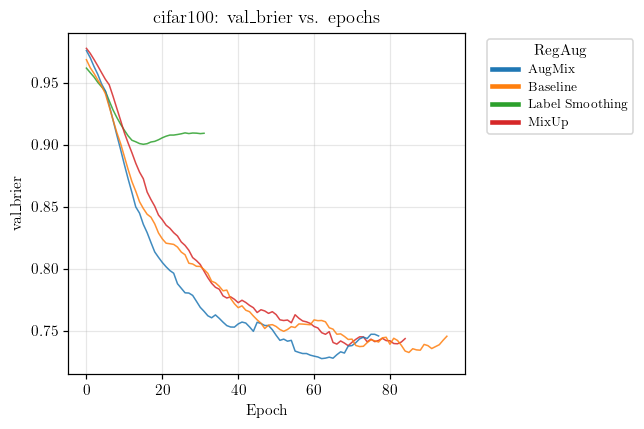

In [81]:
from src.utils_plot import plot_metric_ds

aggregated_path = OUT_DIR / 'RegAug'

mask = hist_df['method'].isin(['Baseline', 'RegAug'])
sub  = hist_df[mask].copy()
sub["method"] = sub["method"].cat.remove_unused_categories()

for metric in history_val_metrics_cols:
    plot_metric_ds(sub, metric=metric, smooth_window=10, max_epoch=100, hue='RegAug', save_pdf=True, path_to_dir=aggregated_path)

Теперь смотрим таблицу с калибровкой и без

In [136]:
from src.utils_plot import build_summary_table

summary_df = build_summary_table(test_df, calib_df)
summary_df

LaTeX table saved to table_calibration_summary.tex


<string>:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


classece                                   brier  \
calibrator                        pre        TS     Platt        IR       pre   
dataset  method_name                                                            
cifar10  Bsce-Gra            0.501136  0.581139  0.658640  0.627236  0.416150   
         Cross Entropy Loss  0.642871  0.662300  0.701449  0.626913  0.342242   
         Dual Focal Loss     0.460272  0.360000  0.648091  0.581141  0.455987   
         Focal Loss          0.529005  0.593086  0.667301  0.631400  0.400183   
cifar100 Bsce-Gra            0.290185  0.314644  0.388316  0.348826  0.698601   
         Cross Entropy Loss  0.286268  0.446585  0.360232  0.300495  0.733261   
         Dual Focal Loss     0.237235  0.309474  0.370488  0.329563  0.735149   
         Focal Loss          0.327653  0.338927  0.406023  0.369707  0.680117   
otto     Bsce-Gra            0.505598  0.594690  0.636979  0.644477  0.351776   
         Cross Entropy Loss  0.618701  0.637238  0.649140  0.586922  0.291212   
         Dual Focal Loss     0.539346  0.600482  0.627963  0.594717  0.353903   
         Focal Loss          0.546946  0.604443  0.639283  0.637990  0.336260   

                                                           
calibrator                         TS     Platt        IR  
dataset  method_name                                       
cifar10  Bsce-Gra            0.380925  0.347055  0.366216  
         Cross Entropy Loss  0.341224  0.317609  0.330505  
         Dual Focal Loss     0.539968  0.368861  0.390318  
         Focal Loss          0.375281  0.336930  0.356990  
cifar100 Bsce-Gra            0.691044  0.716028  0.677151  
         Cross Entropy Loss  0.880811  0.748877  0.717778  
         Dual Focal Loss     0.694474  0.712564  0.685024  
         Focal Loss          0.678963  0.709572  0.668614  
otto     Bsce-Gra            0.310317  0.293177  0.302022  
         Cross Entropy Loss  0.288410  0.284522  0.287012  
         Dual Focal Loss     0.311707  0.293689  0.301140  
         Focal Loss          0.309203  0.294324  0.302301

In [99]:
calib_df.head()

,dataset,model,calibrator,loss,ls,mixup,augmix,accuracy,ece,adaece,classece,brier,config,method,RegAug
0,cifar10,resnet50,temperature,Cross Entropy Loss,0.0,0.0,False,0.7302,0.017804,0.015282,0.652028,0.371175,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Post-hoc+Baseline,Baseline
1,cifar10,resnet50,platt,Cross Entropy Loss,0.0,0.0,False,0.7426,0.026271,0.025239,0.665824,0.351953,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Post-hoc+Baseline,Baseline
2,cifar10,resnet50,isotonic,Cross Entropy Loss,0.0,0.0,False,0.7342,0.025670,0.024181,0.653142,0.366222,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Post-hoc+Baseline,Baseline
3,cifar10,resnet50,bbq,Cross Entropy Loss,0.0,0.0,False,0.1616,0.021466,0.022395,0.373041,0.877129,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Post-hoc+Baseline,Baseline
4,cifar10,resnet50,temperature,Cross Entropy Loss,0.1,0.0,False,0.7749,0.032281,0.029361,0.666287,0.324138,cifar10_resnet50_cross_entropy_ls0.1_mx0.0_noaug,Post-hoc+RegAug,Label Smoothing


In [100]:
test_df.head()

,dataset,model,loss,ls,mixup,augmix,accuracy,ece,adaece,classece,brier,config,method,RegAug
0,cifar10,resnet50,Cross Entropy Loss,0.0,0.0,False,0.7302,0.010877,0.010893,0.627379,0.370983,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_noaug,Baseline,Baseline
1,cifar10,resnet50,Cross Entropy Loss,0.1,0.0,False,0.7749,0.055479,0.055181,0.629715,0.326433,cifar10_resnet50_cross_entropy_ls0.1_mx0.0_noaug,RegAug,Label Smoothing
2,cifar10,resnet50,Cross Entropy Loss,0.0,0.2,False,0.7635,0.042814,0.043310,0.630542,0.331881,cifar10_resnet50_cross_entropy_ls0.0_mx0.2_noaug,RegAug,MixUp
3,cifar10,resnet50,Cross Entropy Loss,0.0,0.0,True,0.7545,0.034155,0.033997,0.683849,0.339672,cifar10_resnet50_cross_entropy_ls0.0_mx0.0_aug,RegAug,AugMix
4,cifar10,resnet50,Focal Loss,0.0,0.0,False,0.7346,0.113463,0.113201,0.552716,0.386456,cifar10_resnet50_focal_ls0.0_mx0.0_noaug,AltLoss,Baseline


In [97]:
for df, name in [(test_df, "test_df"), (calib_df, "calib_df")]:
    dups = df.columns[df.columns.duplicated()].unique()
    print(name, "duplicates:", dups.tolist())


test_df duplicates: []
calib_df duplicates: []


In [126]:
pd.__version__

'2.2.2'